# Liu_Zihan_Final_Project

Name: Zihan Liu
<br>
Github Username: zihan0324
<br>
USC ID: 1534981630

## Import Depedencies

In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
from zipfile import ZipFile

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
# from google.colab import drive
# drive.mount('/content/drive')
# data_head_dir = Path('./drive/MyDrive/Colab Notebooks/data')

data_head_dir = Path('../data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

Mounted at /content/drive


In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
# train_ids = load_text_ids('../train_source_images.txt')
# validate_ids = load_text_ids('../val_source_images.txt')
# test_ids = load_text_ids('../test_source_images.txt')

train_ids = load_text_ids('./drive/MyDrive/Colab Notebooks/train_source_images.txt')
validate_ids = load_text_ids('./drive/MyDrive/Colab Notebooks/val_source_images.txt')
test_ids = load_text_ids('./drive/MyDrive/Colab Notebooks/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

## Loading and pre processing the data

### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [4]:
import random
import tensorflow as tf
from PIL import Image


def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')

        # Convert PTL image into numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])

        # Normaliza the image to the [0, 1] range
        img = img / 255.0

        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 128
batch_size = 64

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

## CNN + MLP

In [5]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomCrop, RandomContrast, RandomTranslation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

### Data Augmentation

In [6]:
# Function to apply the data augmentation to a single image
def data_augmentation(image, label):
    # Data augmentation operations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1) # Random brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2) # Random contrast
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2) # Random saturation
    image = tf.image.random_hue(image, max_delta=0.1) # Random hue
    return image, label

# Apply the data augmentation to the training dataset
tf_dataset_train = tf_dataset_train.map(data_augmentation)


### Construct Model

In [7]:
# Define the model
model = tf.keras.Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(299, 299, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

In [8]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),\
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),\
              metrics=['accuracy'])

### Train Model

In [ ]:
# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ModelCheckpoint to save the best model
mlp_model_dir = '../models/best_mlp_model.h5'
# mlp_model_dir = './drive/MyDrive/Colab Notebooks/models/best_mlp_model.h5'
checkpoint = ModelCheckpoint(mlp_model_dir,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

# Train the model
with tf.device('/device:GPU:0'):
    history = model.fit(
        tf_dataset_train,
        epochs=20,
        validation_data=tf_dataset_val,
        callbacks=[checkpoint, early_stopping]
    )
# history = model.fit(
#     tf_dataset_train,
#     epochs=20,
#     validation_data=tf_dataset_val,
#     callbacks=[checkpoint, early_stopping]
# )

Epoch 1/20
277/277 [==============================] - ETA: 0s - loss: 1.1927 - accuracy: 0.7393
Epoch 1: val_loss improved from inf to 1.26941, saving model to ./drive/MyDrive/Colab Notebooks/models/best_mlp_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


277/277 [==============================] - 245s 864ms/step - loss: 1.1927 - accuracy: 0.7393 - val_loss: 1.2694 - val_accuracy: 0.7505
Epoch 2/20
277/277 [==============================] - ETA: 0s - loss: 1.0200 - accuracy: 0.8116
Epoch 2: val_loss did not improve from 1.26941
277/277 [==============================] - 239s 860ms/step - loss: 1.0200 - accuracy: 0.8116 - val_loss: 1.6957 - val_accuracy: 0.7852
Epoch 3/20
277/277 [==============================] - ETA: 0s - loss: 0.9328 - accuracy: 0.8402
Epoch 3: val_loss improved from 1.26941 to 0.87597, saving model to ./drive/MyDrive/Colab Notebooks/models/best_mlp_model.h5
277/277 [==============================] - 239s 860ms/step - loss: 0.9328 - accuracy: 0.8402 - val_loss: 0.8760 - val_accuracy: 0.9050
Epoch 4/20
277/277 [==============================] - ETA: 0s - loss: 0.8490 - accuracy: 0.8720
Epoch 4: val_loss improved from 0.87597 to 0.78571, saving model to ./drive/MyDrive/Colab Notebooks/models/best_mlp_model.h5
277/277 [=

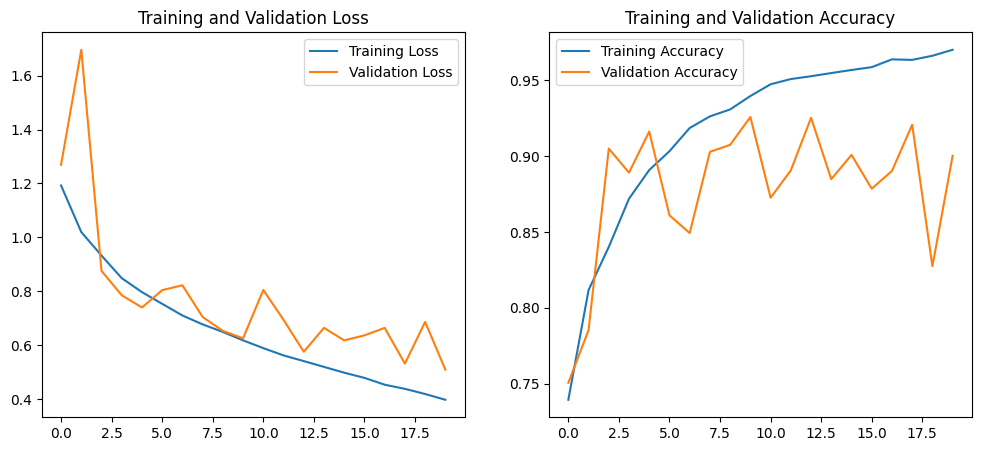

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

## Evaluate Model

In [12]:
# Print model evaluation
print("Training Set:")
training_loss, training_accuracy = model.evaluate(tf_dataset_train)
print(f"Loss:{training_loss}, Accuracy: {training_accuracy}")
print("Validation Set:")
val_loss, val_accuracy = model.evaluate(tf_dataset_val)
print(f"Loss:{val_loss}, Accuracy: {val_accuracy}")
print("ZTest Set:")
test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print(f"Loss:{test_loss}, Accuracy: {test_accuracy}")

Training Set:
277/277 [==============================] - 174s 625ms/step - loss: 1.3329 - accuracy: 0.4740
Loss:1.3328726291656494, Accuracy: 0.4740200936794281
Validation Set:
95/95 [==============================] - 24s 244ms/step - loss: 1.3309 - accuracy: 0.6347
Loss:1.3309191465377808, Accuracy: 0.6346790194511414
ZTest Set:
124/124 [==============================] - 31s 245ms/step - loss: 1.3333 - accuracy: 0.4670
Loss:1.3333077430725098, Accuracy: 0.46700507402420044


In [10]:
import pandas as pd
from sklearn.metrics import classification_report

def report_pred_results(model, dataset):
    y_pred = np.argmax(model.predict(dataset), axis=1)

    y_actual = np.concatenate([y for x, y in dataset], axis=0)

    print(classification_report(y_actual, y_pred, target_names=['Background', 'Frost']))

# model = load_model('../models/best_mlp_model.h5')
# model = load_model('./drive/MyDrive/Colab Notebooks/models/best_mlp_model.h5')
print("Training Set:")
report_pred_results(model, tf_dataset_train)
print("Validation Set:")
report_pred_results(model, tf_dataset_val)
print("Test Set:")
report_pred_results(model, tf_dataset_test)

Training Set:
277/277 [==============================] - 167s 602ms/step
              precision    recall  f1-score   support

  Background       0.40      0.79      0.53      7047
       Frost       0.59      0.21      0.31     10659

    accuracy                           0.44     17706
   macro avg       0.49      0.50      0.42     17706
weighted avg       0.51      0.44      0.39     17706

Validation Set:
95/95 [==============================] - 516s 5s/step
              precision    recall  f1-score   support

  Background       0.64      0.76      0.70      3890
       Frost       0.34      0.22      0.27      2154

    accuracy                           0.57      6044
   macro avg       0.49      0.49      0.48      6044
weighted avg       0.53      0.57      0.54      6044

Test Set:
124/124 [==============================] - 725s 6s/step
              precision    recall  f1-score   support

  Background       0.39      0.82      0.52      3012
       Frost       0.63     